In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm

df = pd.read_csv("../../data/clean_psyphysical_main3.csv")

def confidence_to_levels(conf):
    if conf <= 25:
        return 1  # Low Confidence
    elif 26 <= conf <= 50:
        return 2  # Medium Low Confidence
    elif 51 <= conf <= 75:
        return 3  # Medium High Confidence
    elif conf >= 76:
        return 4  # Very High Confidence
    
# Apply the function to create a new column
df['confidence_levels'] = df['confidence_1'].apply(confidence_to_levels)

#Create unique players
df["player_nb"] = "p" + df["player"].astype(str)
df["player"] = df["player"].astype(str)
df["player"] = df["player"] + df["participant_code"]

#Combine session code with mastok session
df["mk_session"] = df["mk_session"].replace('mk:psyphysical_main:', 'mk_', regex=True)
df["mk_session"] = df["mk_session"] + "_" + df["session_code"]

#Other manipulation variable for interpretation reasons
df["other_manipulation"] = np.where(df["manipulation"] == "submissive", "dominant", "submissive")

#Changed answer between before and after interaction
df["changed_answer"] = df["indv_response"] != df["group_choice"]

df["group_follows_individual"] = df["indv_response"] == df["group_choice"]

#Difference in confidence between before and after interaction - negative values indicates higher confidence
#post interaction.
df["conf_change"] = df["confidence_2"] - df["confidence_1"]

speech_data = pd.read_csv("../../data/speech_data_3.csv")
df = df.merge(speech_data[['player_nb', 'round_nb', 'speech_onset']], on=['player_nb', 'round_nb'], how='left')

#df.to_csv("postprocc_df.csv", index=False)

##### Creating some other useful variables

In [2]:
for index,row in df.iterrows():
    round_nb = row["round_nb"]
    player = row["player_nb"]
    dyad = row["dyad"]
    other_player = dyad.replace(player, "")
    other_index = df[(df['round_nb'] == round_nb) & (df['player_nb'] == other_player)].index
    other_onset = df.loc[other_index, "speech_onset"].values[0]
    onset_diff  = abs(row["speech_onset"] - other_onset)
    
    if pd.isna(onset_diff):
        spoke_first = np.nan
    else:
        spoke_first = row["speech_onset"] < other_onset

    df.loc[index, 'onset_diff'] = onset_diff 
    df.loc[index, 'spoke_first'] = spoke_first


    #dyad conf difference
    other_conf = df.loc[other_index, "confidence_1"].values[0]
    df.loc[index, 'other_conf_1'] = other_conf
    conf_higher = True if row["confidence_1"] > other_conf else False
    abs_conf_diff1 = abs(row["confidence_1"] - other_conf)
    conf_diff1 = row["confidence_1"] - other_conf
    other_conf = df.loc[other_index, "confidence_2"].values[0]
    conf_diff2 = abs(row["confidence_2"] - other_conf)
    df.loc[index, 'abs_dyad_conf_diff1'] = abs_conf_diff1
    df.loc[index, 'abs_dyad_conf_diff2'] = conf_diff2
    df.loc[index, 'conf_diff_1'] = conf_diff1
    df.loc[index, 'higher_conf']      = conf_higher


def abs_conf_diff_to_levels(abs_conf_diff):
    if abs_conf_diff <= 10:
        return 1  # Low Confidence
    elif 10 < abs_conf_diff <= 20:
        return 2  # Medium Low Confidence
    elif 21 <= abs_conf_diff <= 30:
        return 3  # Medium High Confidence
    elif 31 <= abs_conf_diff:
        return 4  # Very High Confidence
    
df['abs_conf_diff_levels'] = df['abs_dyad_conf_diff1'].apply(abs_conf_diff_to_levels)
df['other_conf_1_levels']  = df['other_conf_1'].apply(confidence_to_levels)
df["other_higher_conf"] = df['higher_conf'].map({True: False, False: True})

# Clean up temporary variables
del round_nb, player, dyad, other_player, other_index, other_conf, conf_higher, abs_conf_diff1, conf_diff1, conf_diff2, index, row

## Confidence Measures

[(0.0, 100.0)]

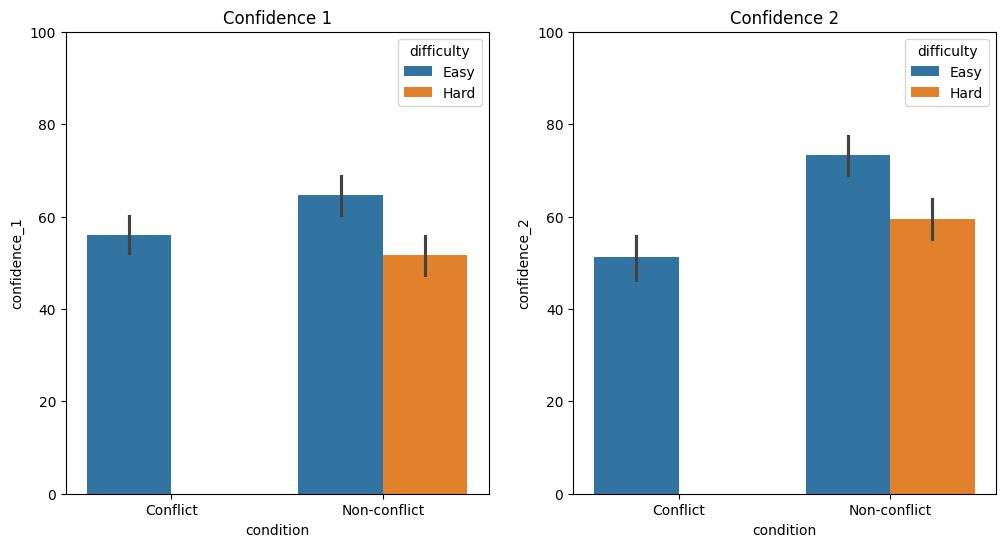

In [3]:
df_analysis1 = df.groupby(["condition", "difficulty", "player"])["confidence_1"].mean().reset_index()
df_analysis2 = df.groupby(["condition", "difficulty", "player"])["confidence_2"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x="condition", y="confidence_1", hue="difficulty", data=df, ax=axes[0])
axes[0].set_title('Confidence 1')
axes[0].set(ylim=(0,100))
sns.barplot(x="condition", y="confidence_2", hue="difficulty", data=df, ax=axes[1])
axes[1].set_title('Confidence 2')
axes[1].set(ylim=(0,100))

#These plots show that confidence is lower for hard trials, and that condidence is lower post-interaction in conflict trials. 
#It also shows a slight uptick between pre and post-interaction for both difficulties in non-conflict conditions.

Text(0.5, 1.0, '')

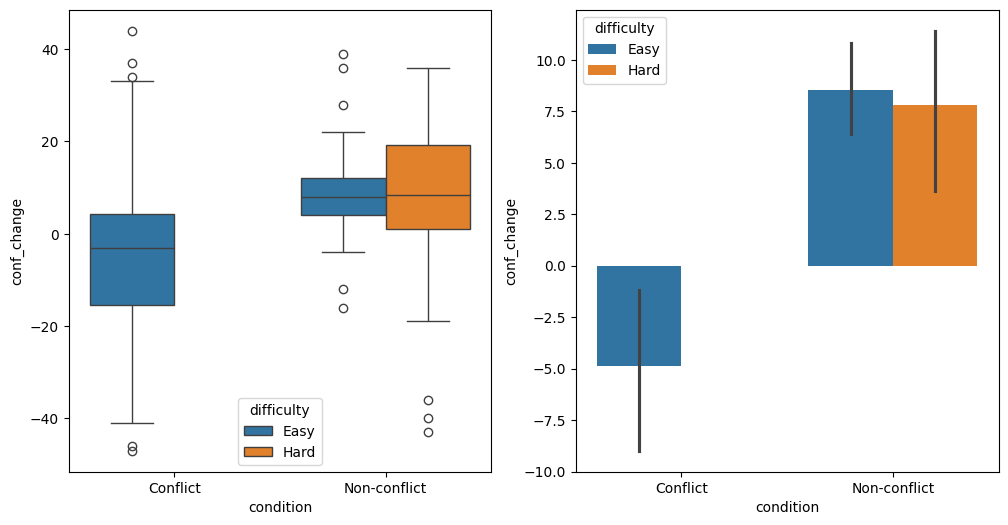

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x="condition", y="conf_change", hue="difficulty", data=df, ax=axes[1])
axes[0].set_title('')
sns.boxplot(x="condition", y="conf_change", hue="difficulty", data=df, ax=axes[0])
axes[1].set_title('')

#To get a more clear picture of what is happening to the confidence rating as a result of the interaction we look at the conf_difference variable. 

#Looking at non-conflict trials, we can see that one tends to increase confidence after interaction, independent of difficulty. 
#Conversely, for conflict trials one tends to have a lower confidence afterh the interaction. 


C:\Users\DanielZander\AppData\Local\Temp\ipykernel_16984\1509577594.py:20: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


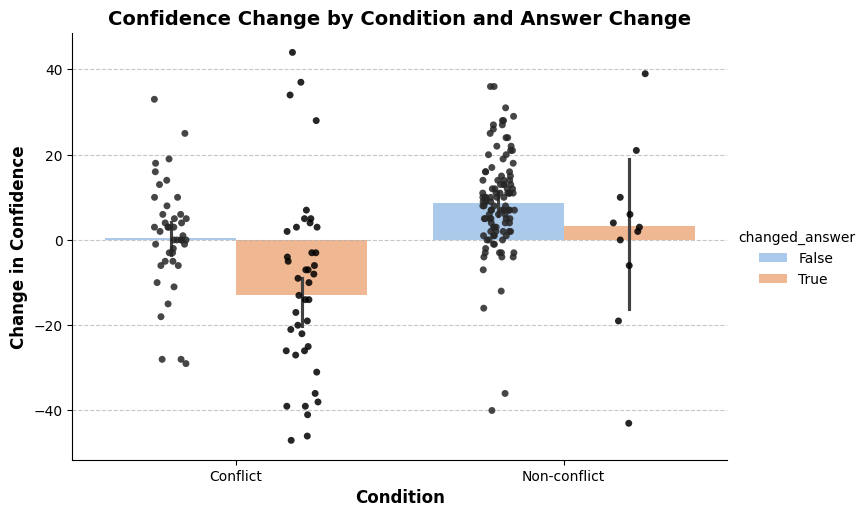

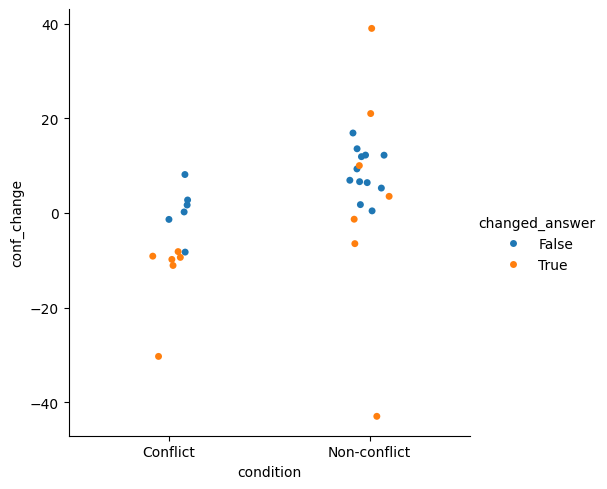

In [5]:
#Another thing we would expect is for the confidence to drop significantly if the participant changes his answer, i.e. cases where his group choice is opposite
#of his individual choice made previously. 

df_analysis = df.groupby(["changed_answer", "condition", "difficulty", "player"])["conf_change"].mean().reset_index()
# Assuming df_analysis and df are already defined
g = sns.catplot(
    x="condition", 
    y="conf_change", 
    kind="bar", 
    data=df_analysis, 
    hue="changed_answer", 
    palette="pastel",  # use a pastel color palette for the bars
    height=5,  # height of the plot
    aspect=1.5,  # width-to-height ratio
    legend_out=True  # place the legend outside the plot
)

# Loop through each facet to add strip plots
for ax in g.axes.flat:
    sns.stripplot(
        x="condition", 
        y="conf_change", 
        hue="changed_answer", 
        data=df, 
        dodge=True,  
        jitter=True,  
        color="black",  
        alpha=0.85,  # slightly lower transparency for points
        ax=ax,  
        legend=False
    )
    
    # Customize axis labels and title
    ax.set_xlabel("Condition", fontsize=12, fontweight='bold')
    ax.set_ylabel("Change in Confidence", fontsize=12, fontweight='bold')
    ax.set_title("Confidence Change by Condition and Answer Change", fontsize=14, fontweight='bold')
    
    # Add gridlines for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)



sns.catplot(x = "condition", y="conf_change", data=df_analysis, hue="changed_answer")

#And this appears to be true for both conditions, although the error bars are uge for non-conflcit conditions. 

#Exclude cases where participants answer the same during conflict -- this happens when one participant is incorrect. 

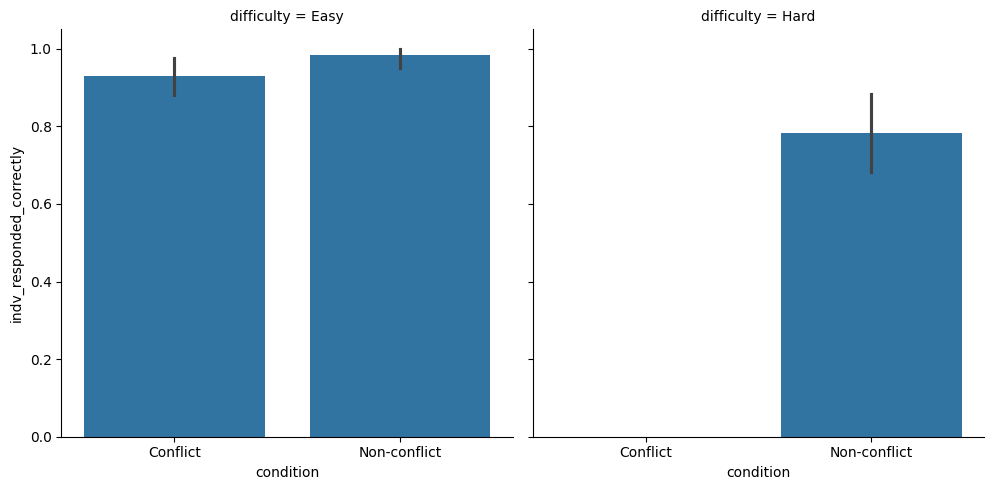

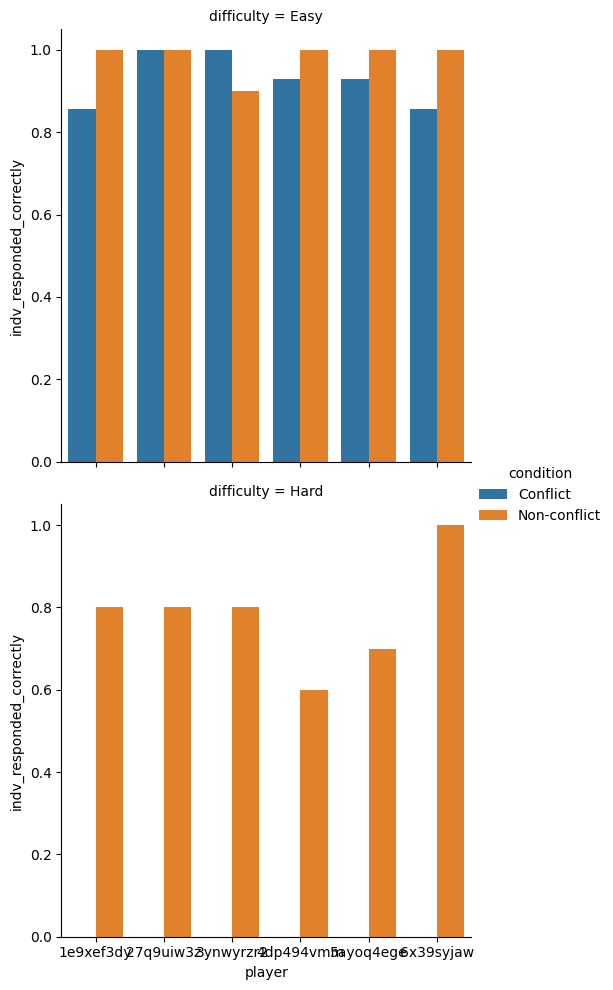

In [6]:

df_analysis = df.groupby(["condition", "difficulty", "player"])["indv_responded_correctly"].mean().reset_index()

sns.catplot(x = "condition", y = "indv_responded_correctly", col="difficulty", data=df_analysis, kind="bar")
sns.catplot(x = "player", y = "indv_responded_correctly", row="difficulty", hue = "condition", data=df_analysis, kind="bar")

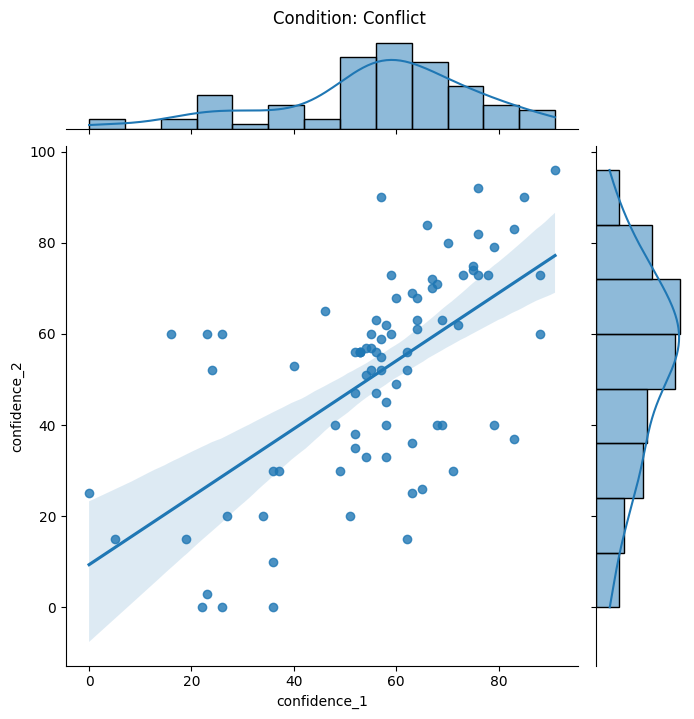

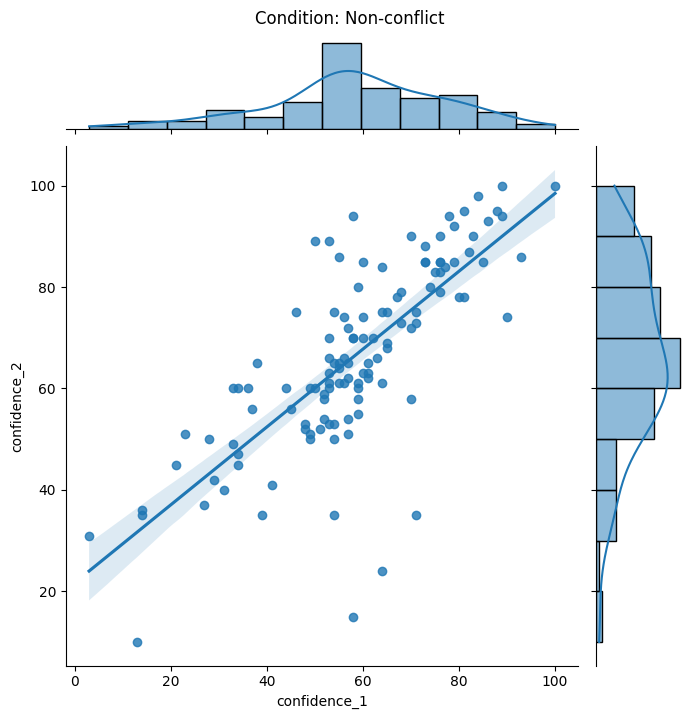

In [7]:
# Loop through each unique condition in the 'condition' column
for condition in df['condition'].unique():
    # Create a subset of the data for the current condition
    subset = df[df['condition'] == condition]
    
    # Create the jointplot for the current condition
    g = sns.jointplot(data=subset, x="confidence_1", y="confidence_2", kind="reg", height=7)
    
    # Set the title for the current plot
    g.fig.suptitle(f'Condition: {condition}', y=1.02)  # Adjust y for title position

### Effects of voice manipulation

<Axes: xlabel='condition', ylabel='conf_change'>

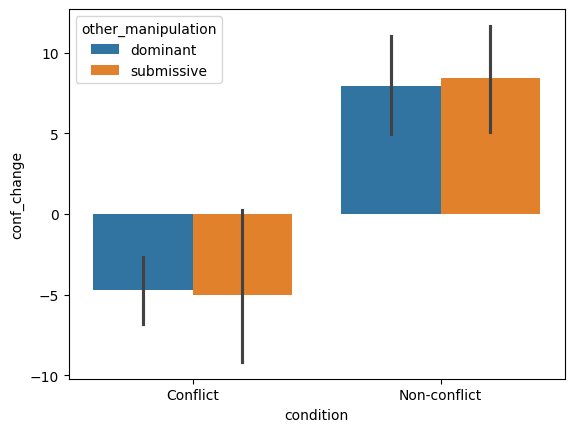

In [8]:
df_analysis = df.groupby(["other_manipulation", "condition", "difficulty", "player"])["conf_change"].mean().reset_index()
sns.barplot(x="condition", y="conf_change", hue="other_manipulation", data=df_analysis)

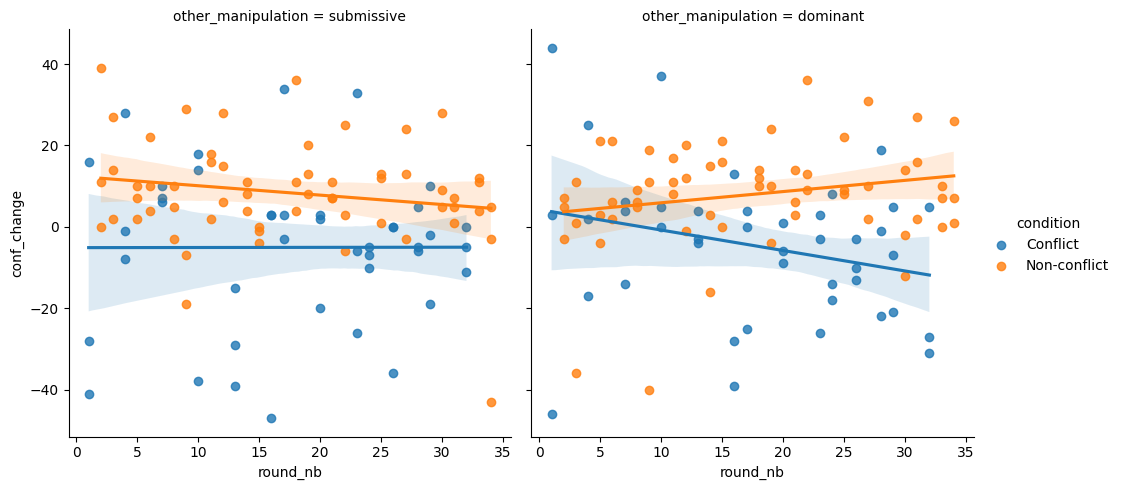

In [9]:
sns.lmplot(x = "round_nb", y = "conf_change", hue = "condition", col="other_manipulation", data=df)

#### Conflict trials

Text(0.5, 1.0, 'bar')

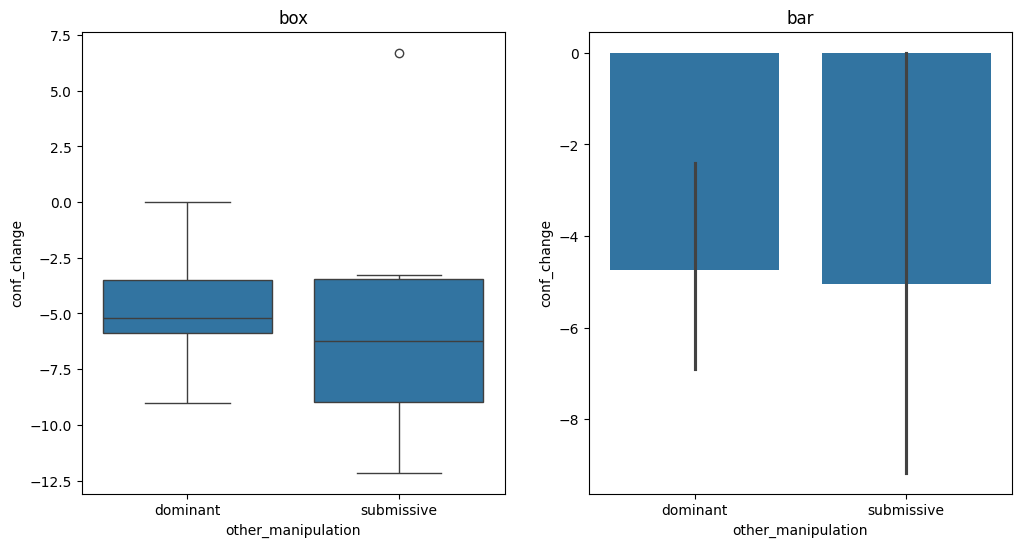

In [10]:
#Lets look only at conflict trials now. 
conflict_trials = df[df["condition"] == "Conflict"]

df_analysis = conflict_trials.groupby(["other_manipulation", "player"])["conf_change"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x="other_manipulation", y="conf_change", data=df_analysis, ax=axes[0])
axes[0].set_title('box')
sns.barplot(x="other_manipulation", y="conf_change", data=df_analysis, ax=axes[1])
axes[1].set_title('bar')

#According to these plots, there is a tendency to be less certain of your choice after being subject to a submissive voice during the interaction, as compared to a dominant one. 
#RECALL THAT THESE ARE CONFLICT TRIALS!

C:\Users\DanielZander\AppData\Local\Temp\ipykernel_16984\2693450402.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  gx = sns.stripplot(
C:\Users\DanielZander\AppData\Local\Temp\ipykernel_16984\2693450402.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  gx = sns.stripplot(


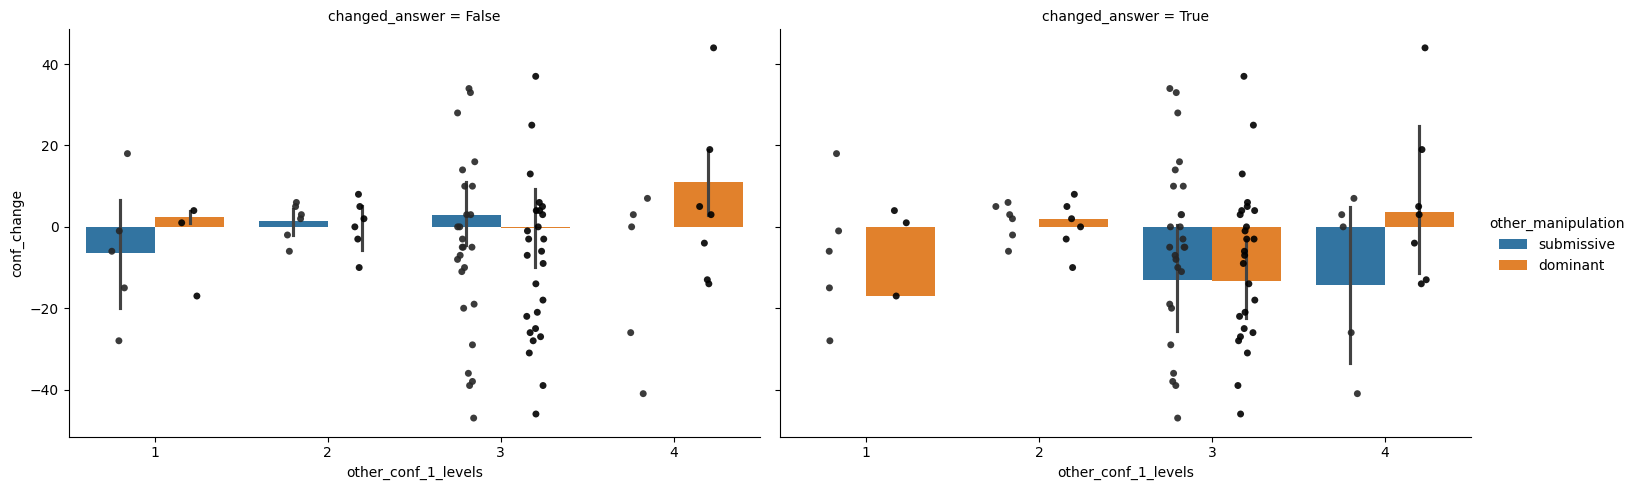

In [11]:
g = sns.catplot(
    x="other_conf_1_levels", 
    y="conf_change", 
    hue="other_manipulation", 
    data=conflict_trials, 
    kind="bar",
    aspect=1.5,
    col = "changed_answer"
)

# Add individual data points on top of the bars using stripplot
for ax in g.axes.flat:  # loop through each facet (if you have multiple)
    gx = sns.stripplot(
        x="other_conf_1_levels", 
        y="conf_change", 
        hue="other_manipulation", 
        data=conflict_trials, 
        dodge=True,  # adjust points based on hue
        jitter=True,  # adds random noise to the points for better visibility
        color="black",  # color for individual points
        alpha=.9,  # transparency for individual points
        ax=ax,  # plot on the same axes,
        legend=False
    )

# Remove the duplicate legend caused by the stripplot

C:\Users\DanielZander\AppData\Local\Temp\ipykernel_16984\992803645.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  gx = sns.stripplot(
C:\Users\DanielZander\AppData\Local\Temp\ipykernel_16984\992803645.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  gx = sns.stripplot(


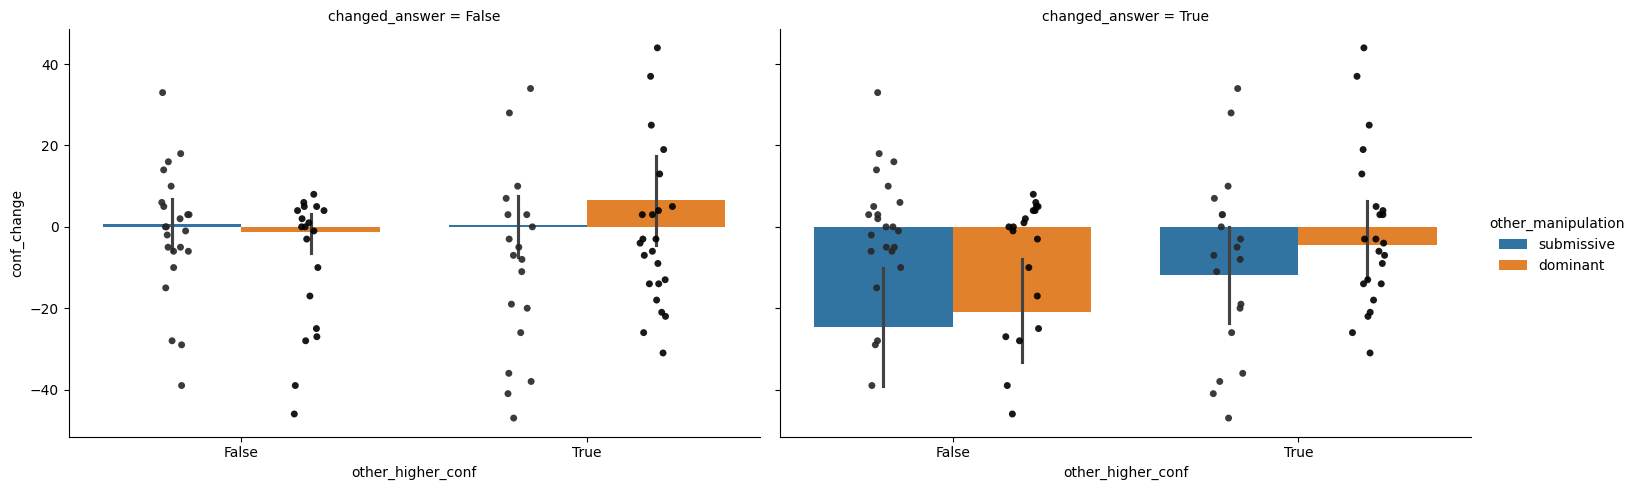

In [12]:
g = sns.catplot(
    x="other_higher_conf", 
    y="conf_change", 
    hue="other_manipulation", 
    data=conflict_trials, 
    kind="bar",
    aspect=1.5,
    col = "changed_answer"
)

# Add individual data points on top of the bars using stripplot
for ax in g.axes.flat:  # loop through each facet (if you have multiple)
    gx = sns.stripplot(
        x="other_higher_conf", 
        y="conf_change", 
        hue="other_manipulation", 
        data=conflict_trials, 
        dodge=True,  # adjust points based on hue
        jitter=True,  # adds random noise to the points for better visibility
        color="black",  # color for individual points
        alpha=.9,  # transparency for individual points
        ax=ax,  # plot on the same axes,
        legend=False
    )


<Axes: xlabel='changed_answer', ylabel='conf_change'>

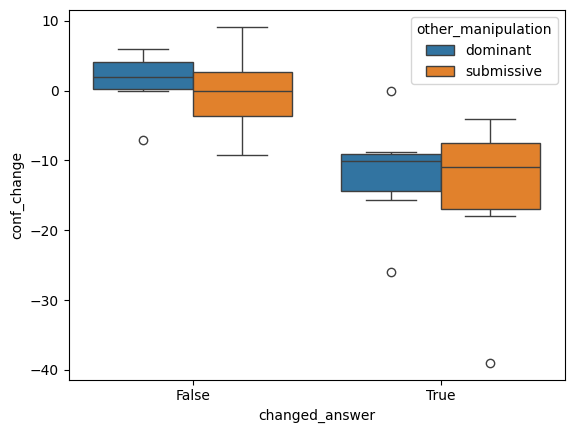

In [13]:
df_analysis = conflict_trials.groupby(["changed_answer", "other_manipulation", "player"])["conf_change"].mean().reset_index()
sns.boxplot(x="changed_answer", y="conf_change", data=df_analysis, hue ="other_manipulation")

## Probability of changing answer

In [14]:
# Convert "True"/"False" strings to boolean values
#df_responded["indv_responded_correctly"] = df_responded["indv_responded_correctly"].map({"True": True, "False": False})
print(df["indv_responded_correctly"].mean())

0.9014778325123153


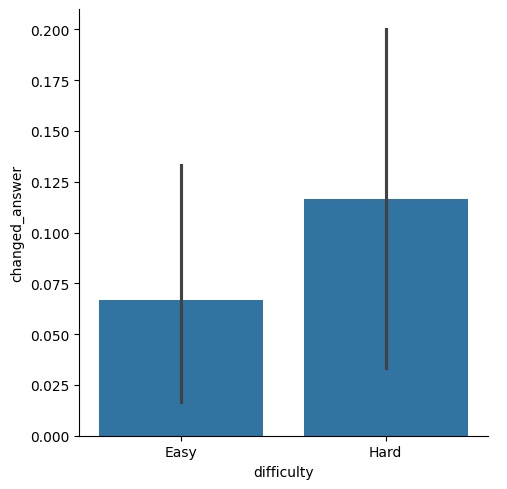

In [15]:
#Lets start by looking at whether you are more likely to change answer for hard trials in non-conflict. In conflict trials we know it will be 50% since half of the participants are 
#forced to change answer in each trial.
df_NC = df[df["condition"] == "Non-conflict"]
df_analysis = df_NC.groupby(["condition", "difficulty", "player"])["changed_answer"].mean().reset_index()
sns.catplot(x = "difficulty", y = "changed_answer", data=df_analysis, kind="bar")

#So a little bit more likely to change answer if the trial is Hard. 

### Effects of manipulation

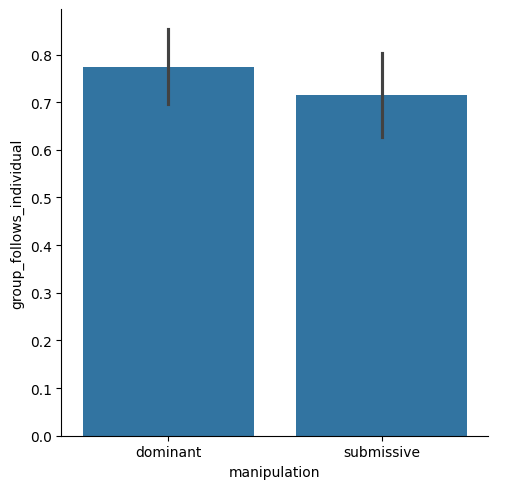

In [16]:
df_analysis = df.groupby(["condition", "manipulation", "difficulty", "player"])["group_follows_individual"].mean().reset_index()
sns.catplot(x = "manipulation", y = "group_follows_individual", data = df, kind="bar")

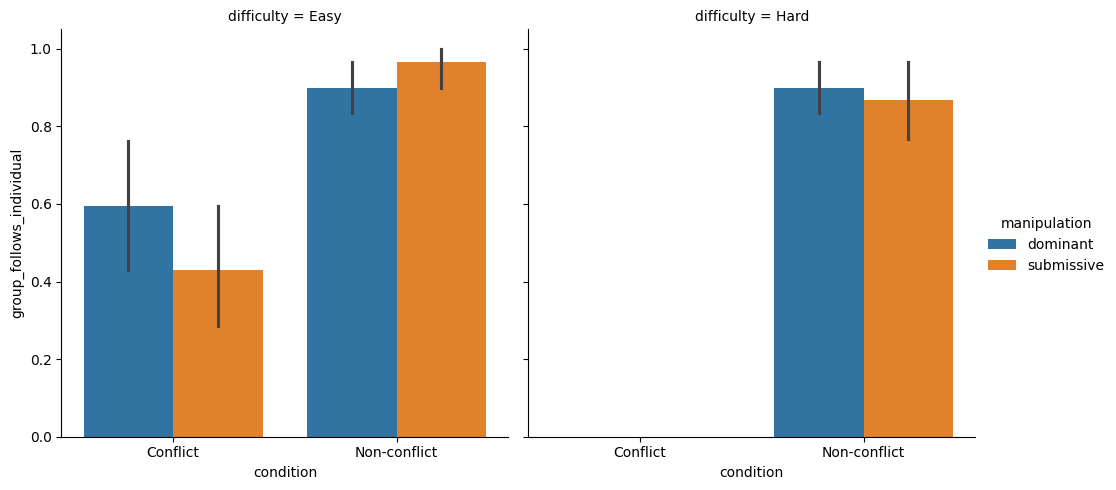

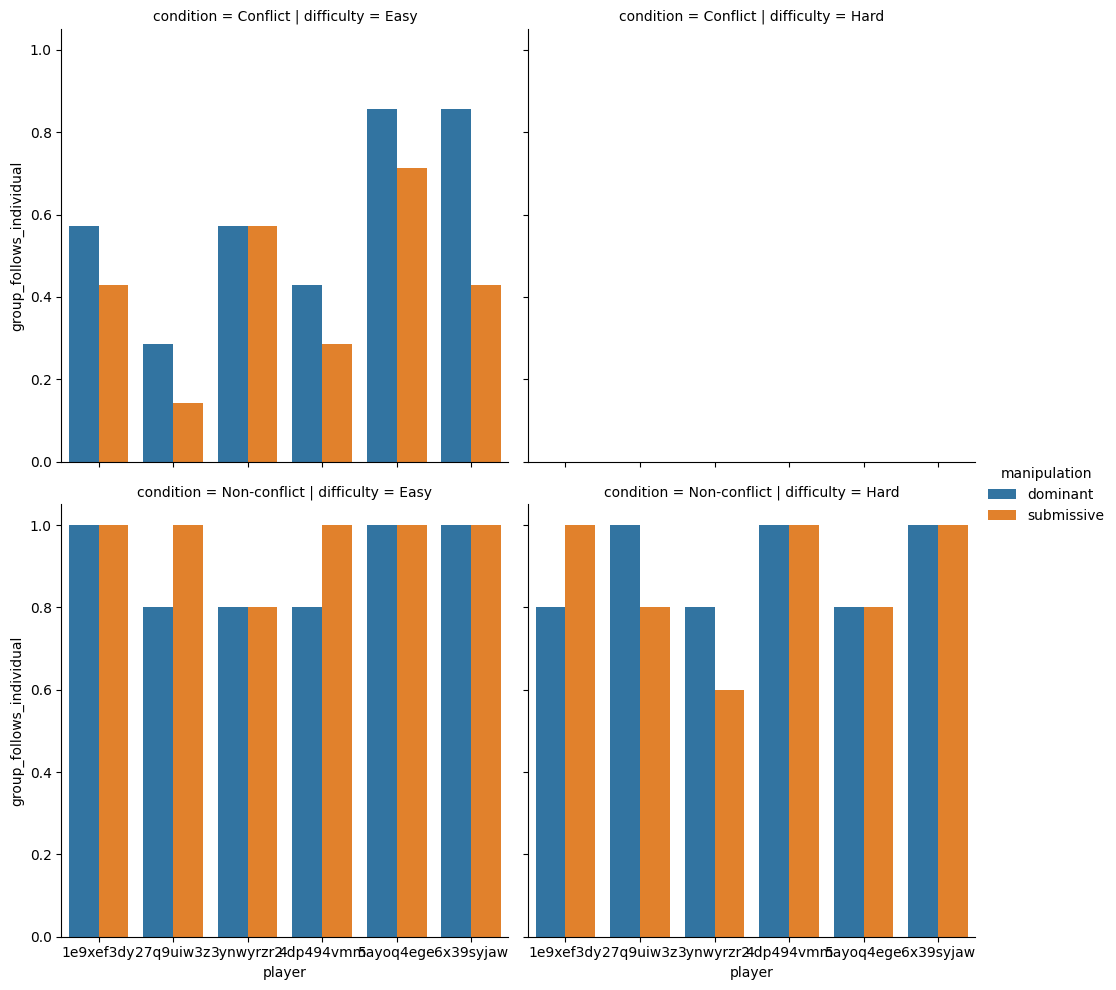

In [17]:
df_analysis = df.groupby(["condition", "manipulation", "difficulty", "player"])["group_follows_individual"].mean().reset_index()
sns.catplot(x = "condition", y="group_follows_individual", hue="manipulation", col = "difficulty", data=df_analysis, kind="bar")

sns.catplot(x = "player", y="group_follows_individual", hue="manipulation", col = "difficulty", row = "condition", data=df_analysis, kind="bar")

C:\Users\DanielZander\AppData\Local\Temp\ipykernel_16984\443979644.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\DanielZander\AppData\Local\Temp\ipykernel_16984\443979644.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.catplot(


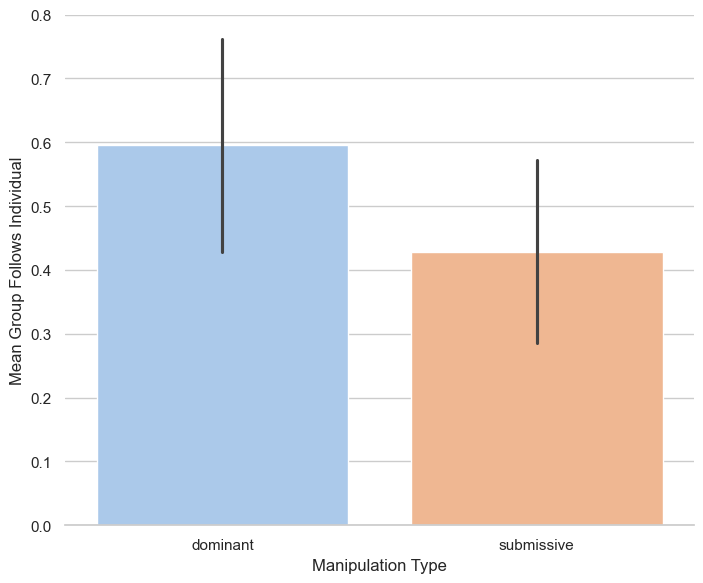

In [18]:
#Conflict only
df_analysis = conflict_trials.groupby(["manipulation", "player"])["group_follows_individual"].mean().reset_index()
# Set the aesthetics of the plots
sns.set(style="whitegrid")  # Set the background style
palette = sns.color_palette("pastel")  # Choose a color palette

# Create the catplot
g = sns.catplot(
    x="manipulation", 
    y="group_follows_individual", 
    data=df_analysis, 
    kind="bar", 
    palette=palette,
    height=6,  # Increase height
    aspect=1.2  # Increase aspect ratio
)

# Customize the plot
g.set_axis_labels("Manipulation Type", "Mean Group Follows Individual")
g.set_titles("Mean Group Follows Individual by Manipulation")
g.despine(left=True)  # Remove the left spine for a cleaner look

# Show the plot
plt.tight_layout()


c:\Users\DanielZander\anaconda3\envs\stim39\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\DanielZander\anaconda3\envs\stim39\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


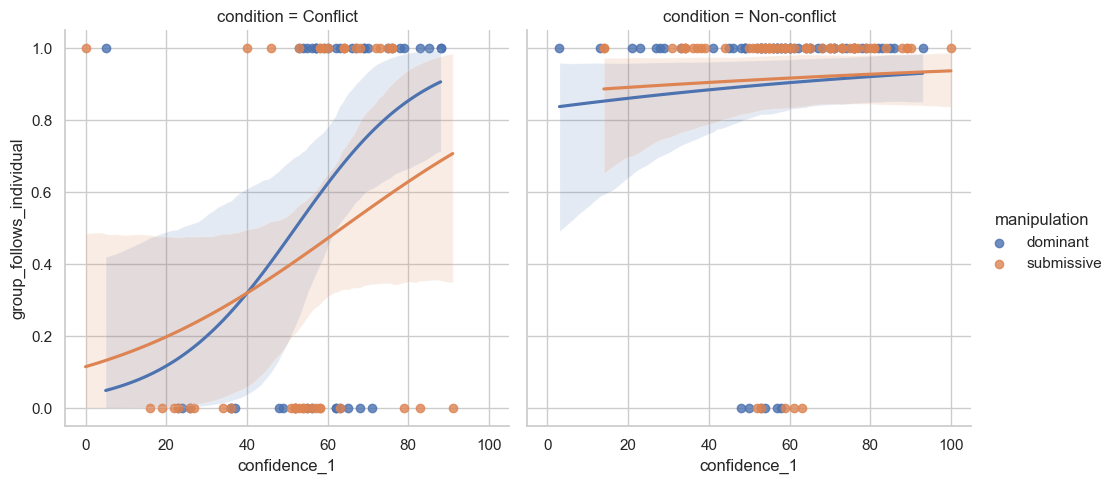

In [19]:
# Plot with logistic regression
sns.lmplot(x="confidence_1", y="group_follows_individual", data=df, logistic=True, hue="manipulation", col = "condition")

c:\Users\DanielZander\anaconda3\envs\stim39\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\DanielZander\anaconda3\envs\stim39\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\DanielZander\anaconda3\envs\stim39\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\DanielZander\anaconda3\envs\stim39\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\DanielZander\anaconda3\envs\stim39\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\DanielZander\anaconda3\envs\stim39\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\D

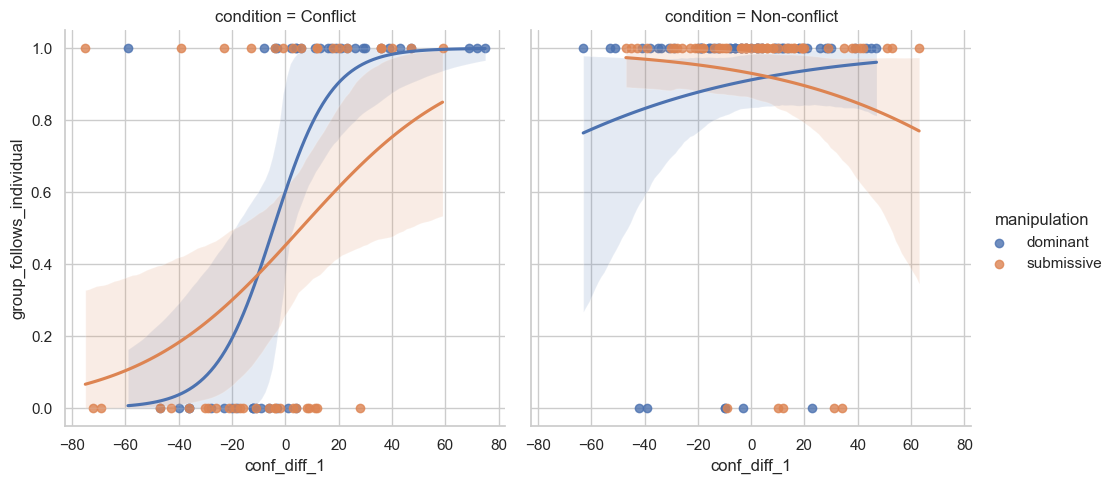

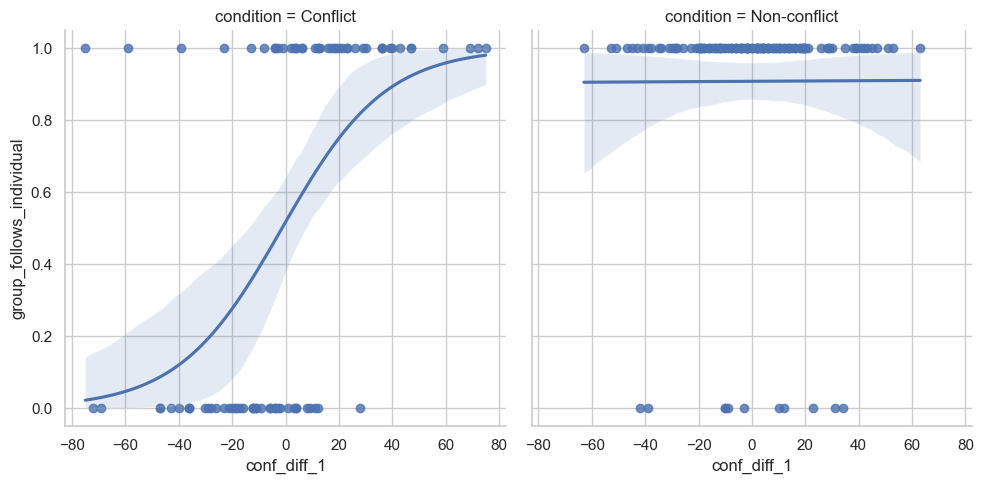

In [20]:
sns.lmplot(x = "conf_diff_1", y= "group_follows_individual", data = df, logistic=True, hue="manipulation", col = "condition")
sns.lmplot(x = "conf_diff_1", y= "group_follows_individual", data = df, logistic=True, col = "condition")


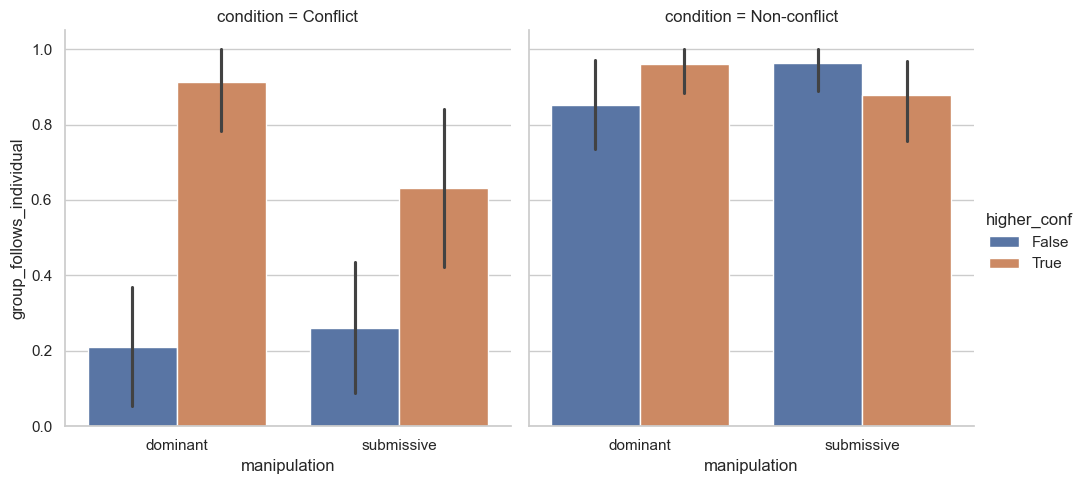

In [21]:
sns.catplot(x = "manipulation", y = "group_follows_individual", data=df, kind="bar", hue = "higher_conf", col = "condition")

C:\Users\DanielZander\AppData\Local\Temp\ipykernel_16984\3353840298.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:green'` for the same effect.

  sns.stripplot(


<Axes: xlabel='confidence_levels', ylabel='group_follows_individual'>

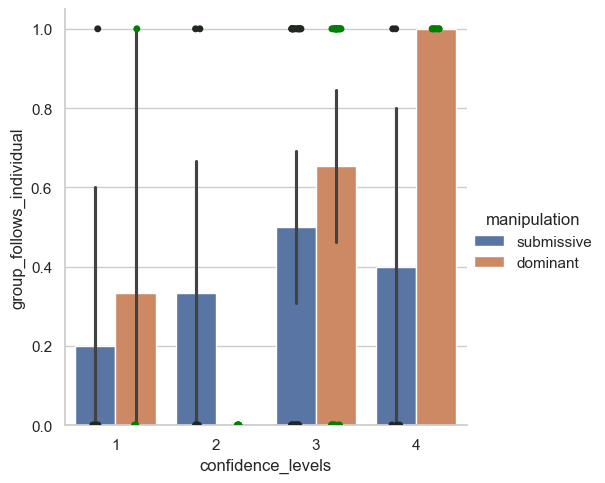

In [22]:
#sns.catplot(x = "confidence_levels", y = "group_follows_individual", data = df, kind="bar", hue= "manipulation", col = "condition")
g = sns.catplot(x = "confidence_levels", y = "group_follows_individual", data = conflict_trials, kind="bar", hue= "manipulation")
sns.stripplot(
        x="confidence_levels", 
        y="group_follows_individual", 
        hue="manipulation", 
        data=conflict_trials, 
        dodge=True,  # adjust points based on hue
        jitter=True,  # adds random noise to the points for better visibility
        color="green",  # color for individual points
        alpha=1,  # transparency for individual points,
        legend=False
    )

<Axes: xlabel='abs_dyad_conf_diff1', ylabel='Count'>

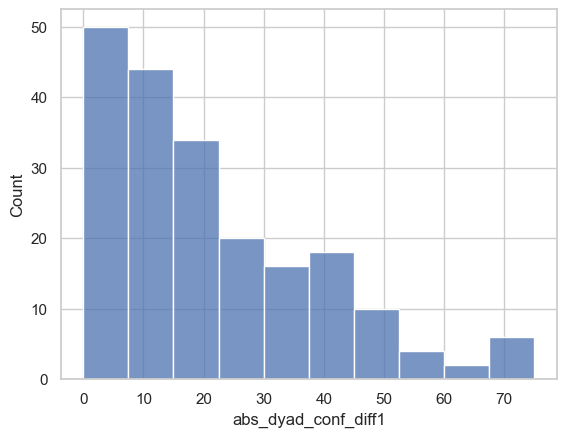

In [23]:
sns.histplot(x="abs_dyad_conf_diff1", data = df)

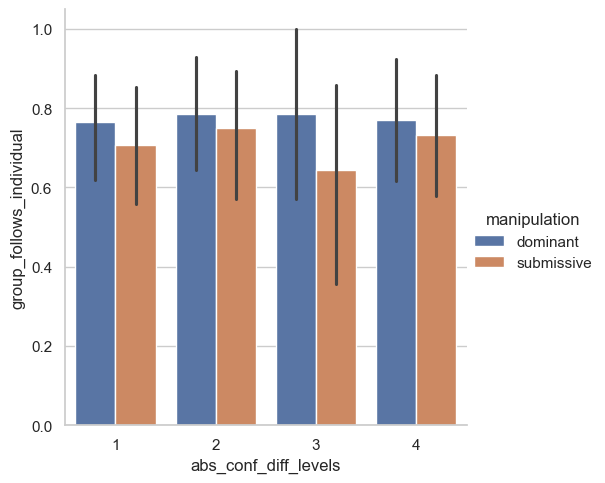

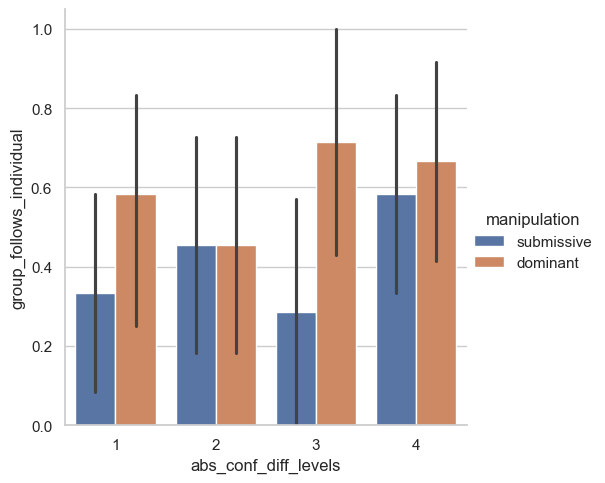

In [24]:
sns.catplot(x = "abs_conf_diff_levels", y = "group_follows_individual", data = df, kind="bar", hue= "manipulation")
sns.catplot(x = "abs_conf_diff_levels", y = "group_follows_individual", data = conflict_trials, kind="bar", hue= "manipulation")

### Reaction time

3019.188235294117


<Axes: xlabel='rt_individual', ylabel='Density'>

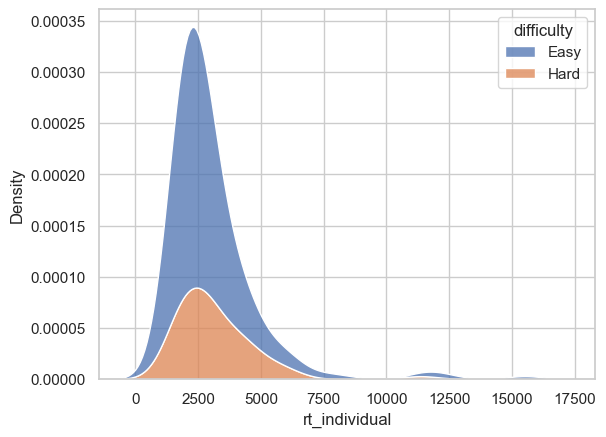

In [25]:
print(df["rt_individual"].mean())

sns.kdeplot(x="rt_individual",multiple="stack", data=df, hue="difficulty")

#MEAN = 2.2 seconds

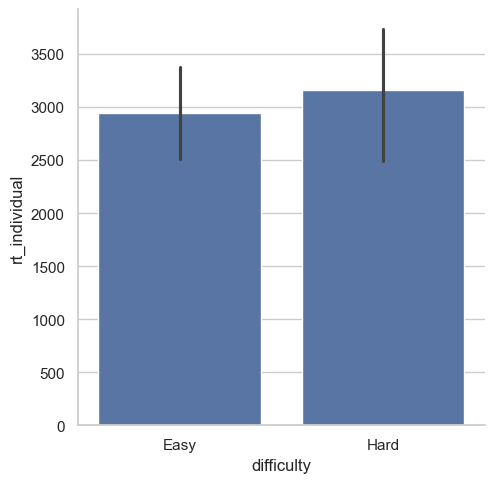

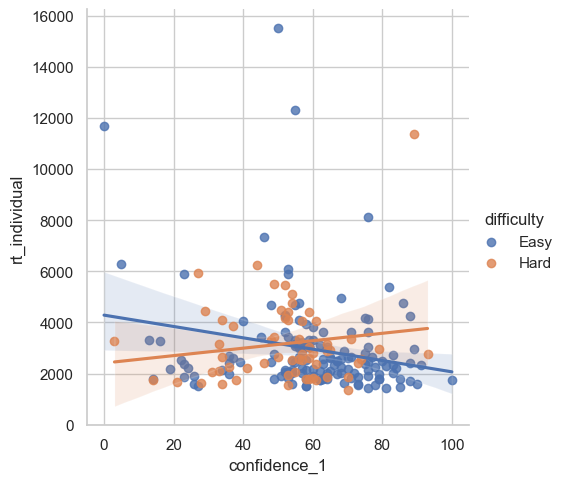

In [26]:
df_analysis = df.groupby(["condition", "difficulty", "player"])["rt_individual"].mean().reset_index()
sns.catplot(x="difficulty", y="rt_individual", data=df_analysis, kind="bar")
sns.lmplot(x="confidence_1", y="rt_individual", data=df, hue="difficulty")

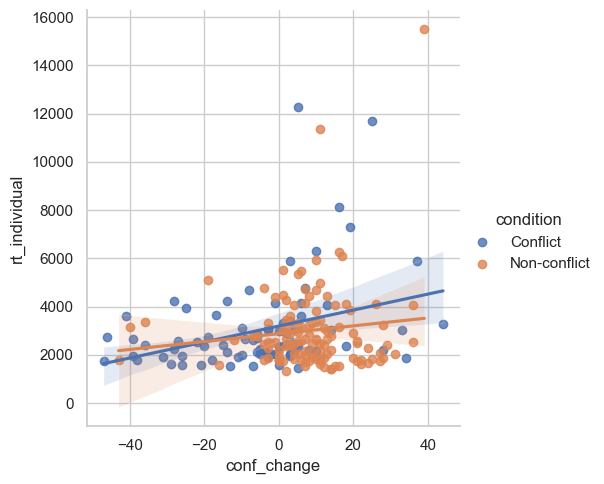

In [27]:
sns.lmplot(x="conf_change", y="rt_individual", data=df, hue = "condition")

#### Group rt

11432.098039215687


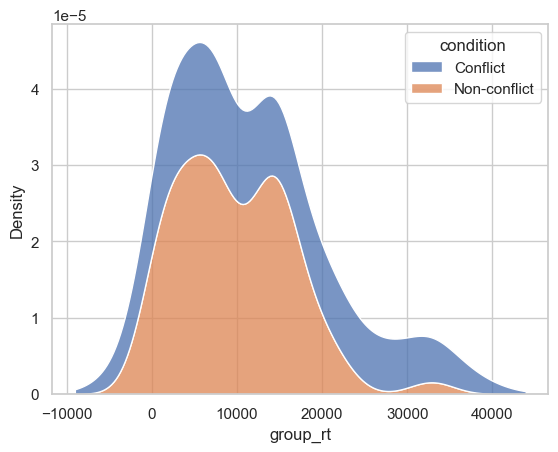

In [28]:
sns.kdeplot(x="group_rt",multiple="stack", data=df, hue="condition")
print(df["group_rt"].mean())

#mean = 4.8 seconds

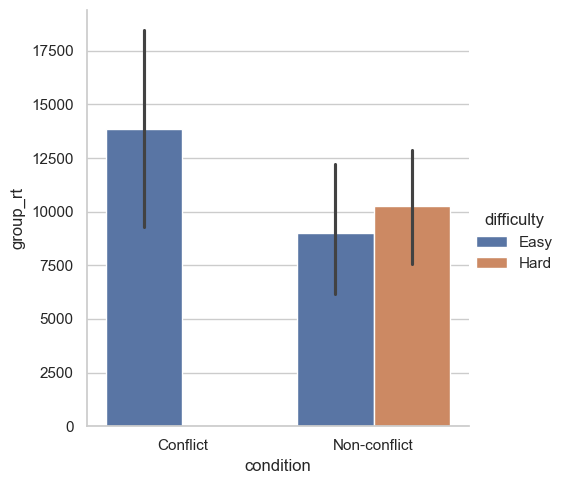

In [29]:
df_analysis = df.groupby(["condition", "difficulty", "dyad"])["group_rt"].mean().reset_index()
sns.catplot(x = "condition", y="group_rt", hue="difficulty", data=df_analysis, kind="bar")

### Speech onset

<Axes: xlabel='speech_onset', ylabel='Density'>

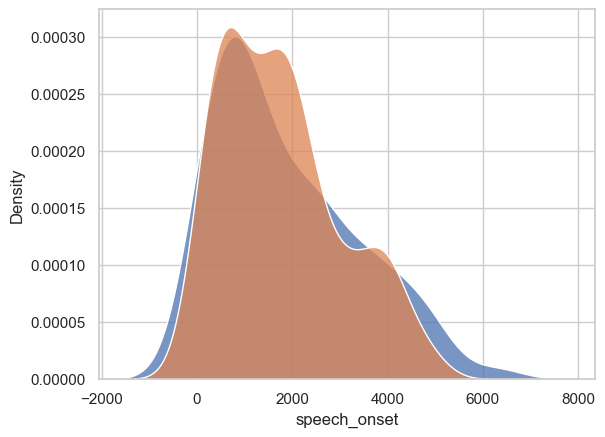

In [30]:
sns.kdeplot(x="speech_onset",multiple="stack", data=df)
sns.kdeplot(x="onset_diff",multiple="stack", data=df)

Text(0.5, 1.0, 'Confidence 2')

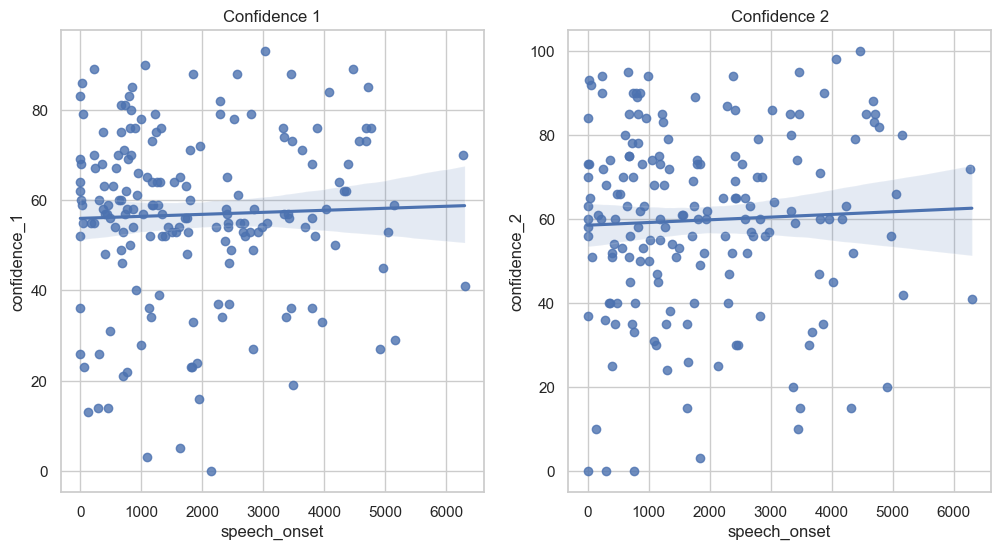

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Use sns.regplot instead of sns.lmplot
sns.regplot(x="speech_onset", y="confidence_1", data=df, ax=axes[0])
axes[0].set_title('Confidence 1')

sns.regplot(x="speech_onset", y="confidence_2", data=df, ax=axes[1])
axes[1].set_title('Confidence 2')

Text(0.5, 1.0, 'conf_2')

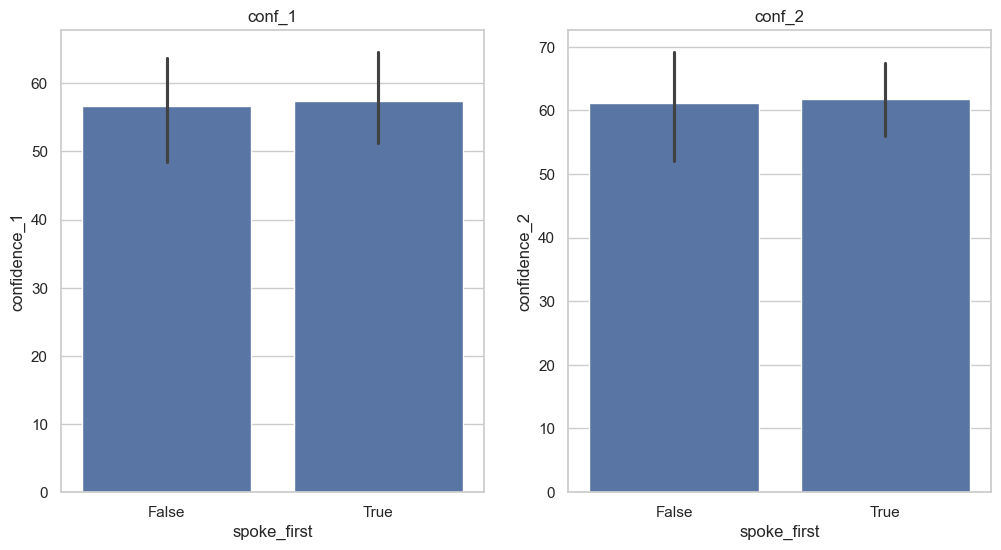

In [32]:
df_analysis1 = df.groupby(["condition", "difficulty", "player","spoke_first"])["confidence_1"].mean().reset_index()
df_analysis2 = df.groupby(["condition", "difficulty", "player","spoke_first"])["confidence_2"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x = "spoke_first", y = "confidence_1", data = df_analysis1, ax=axes[0])
axes[0].set_title('conf_1')
sns.barplot(x = "spoke_first", y = "confidence_2", data = df_analysis2, ax=axes[1])
axes[1].set_title('conf_2')

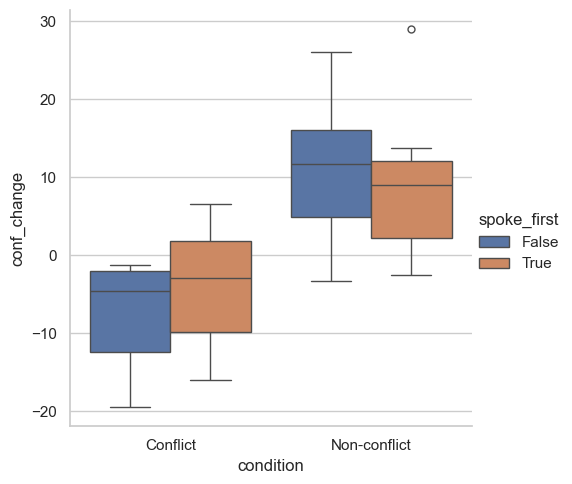

In [33]:
df_analysis = df.groupby(["condition", "difficulty", "player","spoke_first"])["conf_change"].mean().reset_index()
sns.catplot(x = "condition", y = "conf_change", hue="spoke_first", data = df_analysis, kind = "box")

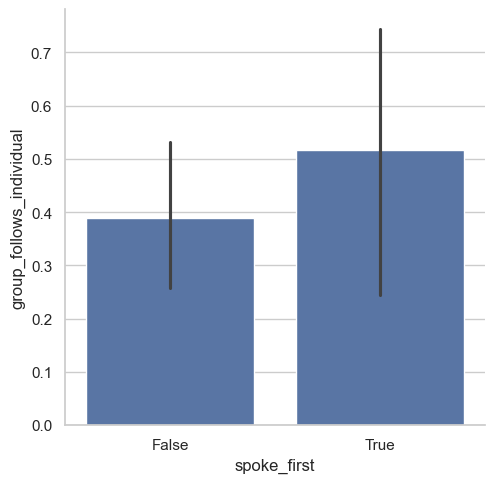

In [34]:
df_analysis = conflict_trials.groupby(["condition", "difficulty", "player","spoke_first"])["group_follows_individual"].mean().reset_index()
sns.catplot(x = "spoke_first", y = "group_follows_individual", data = df_analysis, kind = "bar")

### Personality Measures

<Axes: xlabel='mean_aggresive_dominance', ylabel='Count'>

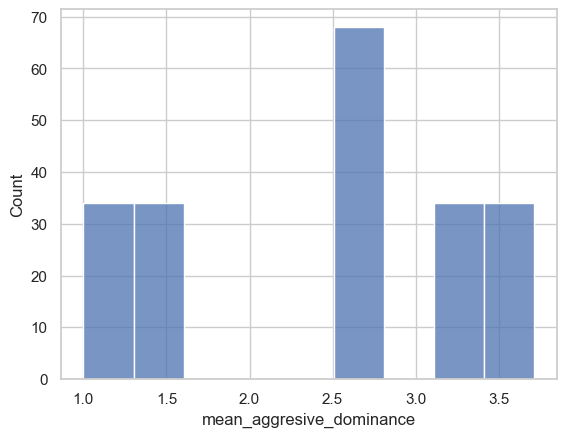

In [35]:
sns.histplot(x="mean_aggresive_dominance", data = df)